In [1]:
from typing import Callable

import matplotlib.pyplot as plt
import torch
from scipy.integrate import solve_ivp
from torch import nn
import numpy as np

## Training Basic Equation (1st Order)

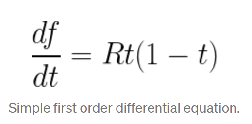

In [2]:
R = 1.0
F0 = 1.0

class NNApproximator(nn.Module):
    def __init__(self, num_hidden: int, dim_hidden: int, act=nn.Tanh()):

        super().__init__()

        self.layer_in = nn.Linear(1, dim_hidden)
        self.layer_out = nn.Linear(dim_hidden, 1)

        num_middle = num_hidden - 1
        self.middle_layers = nn.ModuleList(
            [nn.Linear(dim_hidden, dim_hidden) for _ in range(num_middle)]
        )
        self.act = act

    def forward(self, x):
        out = self.act(self.layer_in(x))
        for layer in self.middle_layers:
            out = self.act(layer(out))
        return self.layer_out(out)


def f(nn: NNApproximator, x: torch.Tensor) -> torch.Tensor:
    return nn(x)


def df(nn: NNApproximator, x: torch.Tensor = None, order: int = 1) -> torch.Tensor:
    df_value = f(nn, x)
    for _ in range(order):
        df_value = torch.autograd.grad(
            df_value,
            x,
            grad_outputs=torch.ones_like(x),
            create_graph=True,
            retain_graph=True,
        )[0]

    return df_value


def compute_loss(
    nn: NNApproximator, x: torch.Tensor = None, verbose: bool = False
) -> torch.float:

    interior_loss = df(nn, x) - R * x * (1 - x)

    boundary = torch.Tensor([0.0])
    boundary.requires_grad = True
    boundary_loss = f(nn, boundary) - F0
    final_loss = interior_loss.pow(2).mean() + boundary_loss ** 2
    return final_loss


def train_model(
    nn: NNApproximator,
    loss_fn: Callable,
    learning_rate: int = 0.01,
    max_epochs: int = 1_000,
) -> NNApproximator:

    loss_evolution = []

    optimizer = torch.optim.SGD(nn.parameters(), lr=learning_rate)
    for epoch in range(max_epochs):

        try:

            loss: torch.Tensor = loss_fn(nn)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if epoch % 1000 == 0:
                print(f"Epoch: {epoch} - Loss: {float(loss):>7f}")

            loss_evolution.append(loss.detach().numpy())

        except KeyboardInterrupt:
            break

    return nn, np.array(loss_evolution)


def check_gradient(nn: NNApproximator, x: torch.Tensor = None) -> bool:

    eps = 1e-4
    dfdx_fd = (f(nn, x + eps) - f(nn, x - eps)) / (2 * eps)
    dfdx_sample = df(nn, x, order=1)

    return torch.allclose(dfdx_fd.T, dfdx_sample.T, atol=1e-2, rtol=1e-2)


Epoch: 0 - Loss: 0.973614
Epoch: 1000 - Loss: 0.005374
Epoch: 2000 - Loss: 0.000354
Epoch: 3000 - Loss: 0.000263
Epoch: 4000 - Loss: 0.000216
Epoch: 5000 - Loss: 0.000187
Epoch: 6000 - Loss: 0.000168
Epoch: 7000 - Loss: 0.000152
Epoch: 8000 - Loss: 0.000140
Epoch: 9000 - Loss: 0.000129
Epoch: 10000 - Loss: 0.000120
Epoch: 11000 - Loss: 0.000112
Epoch: 12000 - Loss: 0.000105
Epoch: 13000 - Loss: 0.000099
Epoch: 14000 - Loss: 0.000093
Epoch: 15000 - Loss: 0.000088
Epoch: 16000 - Loss: 0.000084
Epoch: 17000 - Loss: 0.000080
Epoch: 18000 - Loss: 0.000076
Epoch: 19000 - Loss: 0.000073


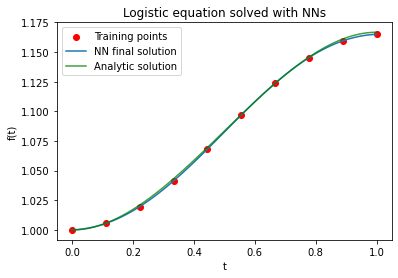

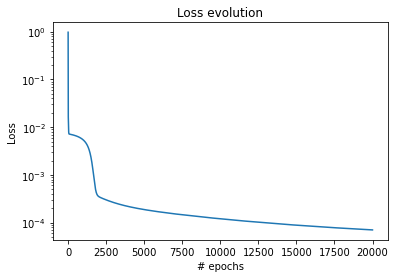

In [3]:
if __name__ == "__main__":
    from functools import partial

    domain = [0.0, 1.0]
    x = torch.linspace(domain[0], domain[1], steps=10, requires_grad=True)
    x = x.reshape(x.shape[0], 1)

    nn_approximator = NNApproximator(4, 10)
    assert check_gradient(nn_approximator, x)

    # f_initial = f(nn_approximator, x)
    # ax.plot(x.detach().numpy(), f_initial.detach().numpy(), label="Initial NN solution")

    # train the PINN
    loss_fn = partial(compute_loss, x=x, verbose=True)
    nn_approximator_trained, loss_evolution = train_model(
        nn_approximator, loss_fn=loss_fn, learning_rate=0.1, max_epochs=20_000
    )

    x_eval = torch.linspace(domain[0], domain[1], steps=100).reshape(-1, 1)

    # numeric solution
    def logistic_eq_fn(x, y):
        return R * x * (1 - x)

    numeric_solution = solve_ivp(
        logistic_eq_fn, domain, [F0], t_eval=x_eval.squeeze().detach().numpy()
    )

    # plotting
    fig, ax = plt.subplots()

    f_final_training = f(nn_approximator_trained, x)
    f_final = f(nn_approximator_trained, x_eval)

    ax.scatter(x.detach().numpy(), f_final_training.detach().numpy(), label="Training points", color="red")
    ax.plot(x_eval.detach().numpy(), f_final.detach().numpy(), label="NN final solution")
    ax.plot(
        x_eval.detach().numpy(),
        numeric_solution.y.T,
        label=f"Analytic solution",
        color="green",
        alpha=0.75,
    )
    ax.set(title="Logistic equation solved with NNs", xlabel="t", ylabel="f(t)")
    ax.legend()

    fig, ax = plt.subplots()
    ax.semilogy(loss_evolution)
    ax.set(title="Loss evolution", xlabel="# epochs", ylabel="Loss")
#     ax.legend()

    plt.show()

#### A first order basic equation was able to be solved using Neural Networks with information from the dynamics equation

## Training Manipulator Equation (2nd Order)

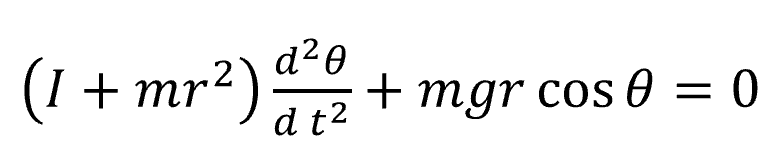

In [4]:
r  = 1     # Center of Mass of the Link in meter
m  = 1     # Mass of the Link in Kg
g  = 10    # Acceleration due to gravity in meter/sec2
I  = 0.5   # Moment of Inertia in Kg.meter2
F0 = 0.0   # Initial Value of the function

class NNApproximator(nn.Module):
    def __init__(self, num_hidden: int, dim_hidden: int, act=nn.Tanh()):

        super().__init__()

        self.layer_in = nn.Linear(1, dim_hidden)
        self.layer_out = nn.Linear(dim_hidden, 1)

        num_middle = num_hidden - 1
        self.middle_layers = nn.ModuleList(
            [nn.Linear(dim_hidden, dim_hidden) for _ in range(num_middle)]
        )
        self.act = act

    def forward(self, x):
        out = self.act(self.layer_in(x))
        for layer in self.middle_layers:
            out = self.act(layer(out))
        return self.layer_out(out)


def f(nn: NNApproximator, x: torch.Tensor) -> torch.Tensor:
    return nn(x)

def df(nn: NNApproximator, x: torch.Tensor = None, order: int = 2) -> torch.Tensor:
    df_value = f(nn, x)
    for _ in range(order):
        df_value = torch.autograd.grad(
            df_value,
            x,
            grad_outputs=torch.ones_like(x),
            create_graph=True,
            retain_graph=True,
        )[0]
    return df_value

def compute_loss(
    nn: NNApproximator, x: torch.Tensor = None, verbose: bool = False) -> torch.float:

    interior_loss = df(nn, x) + ( m*g*r/(I + m* r**2) ) ## For small theta, cos theta = 1

    boundary = torch.Tensor([0.0])
    boundary.requires_grad = True
    boundary_loss = f(nn, boundary) - F0
    final_loss = interior_loss.pow(2).mean() + boundary_loss ** 2
    return final_loss

def train_model(
    nn: NNApproximator,
    loss_fn: Callable,
    learning_rate: int = 0.01,
    max_epochs: int = 1_000,) -> NNApproximator:

    loss_evolution = []

    optimizer = torch.optim.SGD(nn.parameters(), lr=learning_rate)
    
    for epoch in range(max_epochs):
        try:
            loss: torch.Tensor = loss_fn(nn)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if epoch % 1000 == 0:
                print(f"Epoch: {epoch} - Loss: {float(loss):>7f}")

            loss_evolution.append(loss.detach().numpy())

        except KeyboardInterrupt:
            break
    return nn, np.array(loss_evolution)


def check_gradient(nn: NNApproximator, x: torch.Tensor = None) -> bool:

    eps = 1e-4
    dfdx_fd = (f(nn, x + eps) - f(nn, x - eps)) / (2 * eps)
    dfdx_sample = df(nn, x, order=2)

    return torch.allclose(dfdx_fd.T, dfdx_sample.T, atol=1e-2, rtol=1e-2)


Epoch: 0 - Loss: 43.988396
Epoch: 1000 - Loss:     nan
Epoch: 2000 - Loss:     nan
Epoch: 3000 - Loss:     nan
Epoch: 4000 - Loss:     nan
Epoch: 5000 - Loss:     nan
Epoch: 6000 - Loss:     nan
Epoch: 7000 - Loss:     nan
Epoch: 8000 - Loss:     nan
Epoch: 9000 - Loss:     nan
Epoch: 10000 - Loss:     nan
Epoch: 11000 - Loss:     nan
Epoch: 12000 - Loss:     nan
Epoch: 13000 - Loss:     nan
Epoch: 14000 - Loss:     nan
Epoch: 15000 - Loss:     nan
Epoch: 16000 - Loss:     nan
Epoch: 17000 - Loss:     nan
Epoch: 18000 - Loss:     nan
Epoch: 19000 - Loss:     nan


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


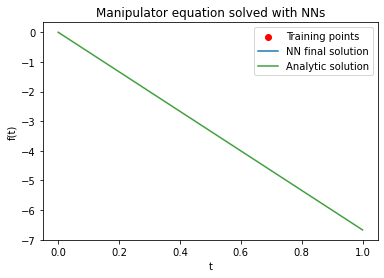

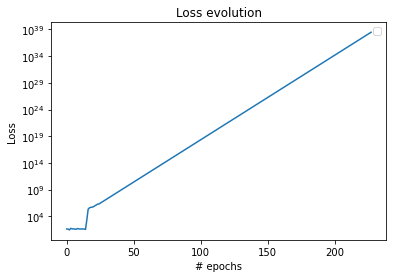

In [5]:
if __name__ == "__main__":
    from functools import partial

    domain = [0.0, 1.0]
    x = torch.linspace(domain[0], domain[1], steps=10, requires_grad=True)
    x = x.reshape(x.shape[0], 1)

    nn_approximator = NNApproximator(4, 10)
#     assert check_gradient(nn_approximator, x)

    # train the PINN
    loss_fn = partial(compute_loss, x=x, verbose=True)
    nn_approximator_trained, loss_evolution = train_model(
        nn_approximator, loss_fn=loss_fn, learning_rate=0.1, max_epochs=20_000
    )

    x_eval = torch.linspace(domain[0], domain[1], steps=100).reshape(-1, 1)

    # numeric solution
    def manipulator_eq_fn(x, y):
        return ( -m*g*r/(I + m* r**2) )
                
    numeric_solution = solve_ivp(manipulator_eq_fn, domain, [F0], t_eval=x_eval.squeeze().detach().numpy() )

    # plotting
    fig, ax = plt.subplots()

    f_final_training = f(nn_approximator_trained, x)
    f_final = f(nn_approximator_trained, x_eval)

    ax.scatter(x.detach().numpy(), f_final_training.detach().numpy(), label="Training points", color="red")
    ax.plot(x_eval.detach().numpy(), f_final.detach().numpy(), label="NN final solution")
    ax.plot(
        x_eval.detach().numpy(),
        numeric_solution.y.T,
        label=f"Analytic solution",
        color="green",
        alpha=0.75,
    )
    ax.set(title="Manipulator equation solved with NNs", xlabel="t", ylabel="f(t)")
    ax.legend()

    fig, ax = plt.subplots()
    ax.semilogy(loss_evolution)
    ax.set(title="Loss evolution", xlabel="# epochs", ylabel="Loss")
    ax.legend()

    plt.show()